## Домашнее задание №5. Attention & seq2seq
Сдача задания производится по адресу `bdt-mf-ml-nlp-2020-q4@bigdatateam.org`

В теме письма указать: "HW5:Seq2Seq. ФИО"

Если какие-то библиотеки недоступны, можно установить их в используемое окружение (environment), например `my_env`, используя пакетный менеджер `pip`: 

```
conda activate my_env
pip install pandas 
```

Пример настройки окружения и `requirements.txt` доступны в репозитории: https://github.com/big-data-team/nlp-course

In [1]:
import os

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output 
%matplotlib inline

### Часть 1. Механизма внимания / Attention mechanism (35%)
В первой части задания вам предстоит реализовать механизм внимания (и конкретно подсчета attention scores). В реальных задачах основное внимание фокусируется на построении всего пайплайна работы с данными, поэтому в первой части этого задания вам предстоит работать с простыми синтетическими данными. Для реализации Attention нам понадобится только библиотека `numpy`.

Вам предстоит реализовать как `dot product` attention (основанный на скалярном произведении), так и `additive` (аддитивный) и `multiplicative` (мультипликативный) варианты. Они различаются лишь способом подсчета attention scores. 

__Обращаем ваше внимание, при вычислении attention scores не должны использоваться циклы, только векторные/матричные операции__.
![](https://raw.githubusercontent.com/neychev/small_DL_repo/master/miscellaneous/attention_types.jpg)

Text(0.5, 1.0, 'Decoder state')

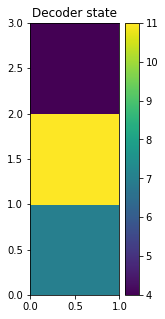

In [ ]:
decoder_hidden_state = np.array([7, 11, 4]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(decoder_hidden_state)
plt.colorbar()
plt.title('Decoder state')

#### Dot product attention (7%)
Рассмотрим единственное состояние энкодера. Его размернось [число признаков x 1]

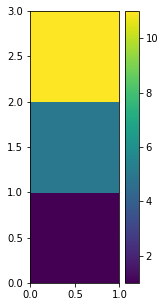

In [ ]:
single_encoder_hidden_state = np.array([1, 5, 11]).astype(float)[:, None]
plt.figure(figsize=(2, 5))
plt.pcolormesh(single_encoder_hidden_state)
plt.colorbar()

Для подсчета dot product attention score достаточно воспользоваться `np.dot`:

In [ ]:
np.dot(decoder_hidden_state.T, single_encoder_hidden_state)

array([[106.]])

Пусть теперь у нас есть несколько скрытых состояний энкодера:

In [ ]:
encoder_hidden_states = np.array([
    [1, 5, 11],
    [7, 4, 1],
    [8, 12, 2],
    [-9, 0, 1]
    
]).astype(float).T

In [ ]:
encoder_hidden_states

array([[ 1.,  7.,  8., -9.],
       [ 5.,  4., 12.,  0.],
       [11.,  1.,  2.,  1.]])

Каждый столбец соответствует одному из скрытых состояний.

In [ ]:
np.dot(decoder_hidden_state.T, encoder_hidden_states)#.shape

array([[106.,  97., 196., -59.]])

##### Dot product attention score
Реализуйте функцию, которая позволяет посчитать dot product attention scores для всех скрытых состояний энкодера

In [ ]:
def dot_product_attention_score(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (1, n_states)
        Array with dot product attention scores
    '''
    
    return np.dot(decoder_hidden_state.T, encoder_hidden_states)

In [ ]:
dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)

array([[106.,  97., 196., -59.]])

##### Softmax
Теперь реализуйте функцию softmax. Обращаем ваше внимание, для численной устойчивости из вектора полезно вычесть максимальное значение

In [ ]:
def softmax(vector):
    '''
    vector: np.array of shape (n, m)
    
    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    '''
    return vector / vector.sum(axis=1)[:,None]

In [ ]:
example_softmax_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))

In [ ]:
example_softmax_vector

array([[ 0.31176471,  0.28529412,  0.57647059, -0.17352941]])

##### Attention vector
Используя полученные веса для состояний, вычислите attention vector на основе скрытых состояний энкодера. Затем реализуйте функцию `dot_product_attention`, которая реализует все эти действия вместе.

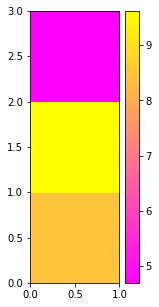

In [ ]:
attention_vector = example_softmax_vector.dot(encoder_hidden_states.T).T

plt.figure(figsize=(2, 5))
plt.pcolormesh(attention_vector, cmap='spring')
plt.colorbar()

In [ ]:
def dot_product_attention(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (n_features, 1)
        Final attention vector
    '''
    
    vector = np.dot(decoder_hidden_state.T, encoder_hidden_states)   
    return vector / vector.sum(axis=1)[:,None]

In [ ]:
dot_product_attention(decoder_hidden_state, encoder_hidden_states)

array([[ 0.31176471,  0.28529412,  0.57647059, -0.17352941]])

#### Multiplicative attention (14%)
Теперь реализуйте multiplicative attention. В качестве матрицы весов можете использовать `W_mult`. Т.к. multiplicative attention позволяет работать с состояниями энкодера и декодера различных размерностей, состояния энкодера будут обновлены.

In [ ]:
encoder_hidden_states_complex = np.array([
    [1, 5, 11, 4, -4],
    [7, 4, 1, 2, 2],
    [8, 12, 2, 11, 5],
    [-9, 0, 1, 8, 12]
    
]).astype(float).T

W_mult = np.array([
    [-0.78, -0.97, -1.09, -1.79,  0.24],
    [ 0.04, -0.27, -0.98, -0.49,  0.52],
    [ 1.08,  0.91, -0.99,  2.04, -0.15]
])

In [ ]:
def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_dec, n_features_enc)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    
    vector = np.dot(np.dot(decoder_hidden_state.T, W_mult), encoder_hidden_states)
    return vector / vector.sum(axis=1)[:,None]

In [ ]:
multiplicative_attention(decoder_hidden_state, encoder_hidden_states_complex, W_mult)

array([[0.56240077, 0.09439089, 0.32266723, 0.02054111]])

#### Additive attention (14%)
И наконец реализуйте additive attention. В качестве матриц весов можете использовать `W_add_enc` и `W_add_dec`. В качестве вектора весов можете использовать `v_add`. Также можно воспользоваться `np.tanh`.

In [ ]:
v_add = np.array([[-0.35, -0.58,  0.07,  1.39, -0.79, -1.78, -0.35]]).T

W_add_enc = np.array([
    [-1.34, -0.1 , -0.38,  0.12, -0.34],
    [-1.  ,  1.28,  0.49, -0.41, -0.32],
    [-0.39, -1.38,  1.26,  1.21,  0.15],
    [-0.18,  0.04,  1.36, -1.18, -0.53],
    [-0.23,  0.96,  1.02,  0.39, -1.26],
    [-1.27,  0.89, -0.85, -0.01, -1.19],
    [ 0.46, -0.12, -0.86, -0.93, -0.4 ]
])

W_add_dec = np.array([
    [-1.62, -0.02, -0.39],
    [ 0.43,  0.61, -0.23],
    [-1.5 , -0.43, -0.91],
    [-0.14,  0.03,  0.05],
    [ 0.85,  0.51,  0.63],
    [ 0.39, -0.42,  1.34],
    [-0.47, -0.31, -1.34]
])

In [ ]:
def additive_attention(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    v_add: np.array of shape (n_features_int, 1)
    W_add_enc: np.array of shape (n_features_int, n_features_enc)
    W_add_dec: np.array of shape (n_features_int, n_features_dec)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    
    vector = np.dot(v_add.T, np.tanh(np.dot(W_add_dec, decoder_hidden_state) + np.dot(W_add_enc, encoder_hidden_states)))   
    return vector / vector.sum(axis=1)[:,None]

In [ ]:
additive_attention(decoder_hidden_state, encoder_hidden_states_complex, v_add, W_add_enc, W_add_dec)

array([[0.31771039, 0.10350777, 0.10463829, 0.47414355]])

______

Поздравляем! Конечно, в реальных задачах часто используются уже готовые реализации Attention: это еще один классический слой, различные варианты которого доступны для большинства популярных фреймворков.

Впереди вас ждет вторая часть задания.

### Часть 2. Seq2seq (65%)

В данной части задания вам предстоит построить систему машинного перевода (пока что очень простую). А именно – научиться транслитерации, т.е. решать следующую задачу:

```
аббревиатура –> abbreviatura
август –> avgust
```

В данном задании мы воспользуемся достаточно простым решением на основе архитектуры encoder-decoder.

В качестве данных будем использовать Словарь А. А. Зализняка (оригинальный набор данных доступен по [ссылке](http://speakrus.ru/dict/index.htm)). Предобработанный набор данных доступен ниже. Он представляет собой пару из того же словаря (в кодировке Unicode) и его транслитерации.

In [2]:
!wget -nc https://raw.githubusercontent.com/neychev/small_DL_repo/master/miscellaneous/zdf_unicode_original.txt
!wget -nc https://raw.githubusercontent.com/neychev/small_DL_repo/master/miscellaneous/zdf_unicode_translit.txt

--2021-01-29 23:43:01--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/miscellaneous/zdf_unicode_original.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1982338 (1.9M) [text/plain]
Saving to: ‘zdf_unicode_original.txt’

zdf_unicode_origina 100%[===================>]   1.89M  --.-KB/s    in 0.04s   

2021-01-29 23:43:01 (49.8 MB/s) - ‘zdf_unicode_original.txt’ saved [1982338/1982338]

--2021-01-29 23:43:01--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/miscellaneous/zdf_unicode_translit.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent

Мы будем работать с текстом на уровне символов, т.е. каждый токен (за исключением технических) является символом. Каждое слово – отдельная последовательность. Также стоит учесть, что все слова сразу предоставлены в нижнем регистре.

Для работы с данным текстом нам понадобятся наборы используемых токенов. Они уже сгенерированы и доступны ниже.

In [3]:
cyrillic_symbols = [
    '-', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к',
    'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц',
    'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё'
] + ['<BOS>'] + ['<EOS>'] + ['<PAD>']

latin_symbols = [
    '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l',
    'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z'
] + ['<BOS>'] + ['<EOS>'] + ['<PAD>']

cyrillic_mapper = {symbol: idx for idx, symbol in enumerate(cyrillic_symbols)}
latin_mapper = {symbol: idx for idx, symbol in enumerate(latin_symbols)}

def symbols_to_indices(symbols_string, mapper):
    symbols_string = symbols_string.replace('\n', '')
    return [mapper['<BOS>']] + [mapper[symbol] for symbol in symbols_string] + [mapper['<EOS>']]

Пример преобразования слова в последовательность индексов:

In [4]:
symbols_to_indices('задание\n', cyrillic_mapper)

[34, 8, 1, 5, 1, 14, 9, 6, 35]

Ниже доступна преобразованная версия датасета для данной задачи. Каждому индексу соответствует слово и его транслитерация.

In [5]:
class TranslitDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        with open(os.path.join(path, 'zdf_unicode_original.txt'), 'r') as iofile:
            words_original_raw = iofile.readlines()
            
        with open(os.path.join(path, 'zdf_unicode_translit.txt'), 'r') as iofile:
            words_translit_raw = iofile.readlines()
        
        assert len(words_original_raw) == len(words_translit_raw), \
        'Different number of original and translit words'
        
        self.words_original = [
            torch.LongTensor(symbols_to_indices(symbols_string, cyrillic_mapper))
            for symbols_string in words_original_raw
        ]
        
        self.words_translit = [
            torch.LongTensor(symbols_to_indices(symbols_string, latin_mapper))
            for symbols_string in words_translit_raw
        ]

    def __len__(self):
        return len(self.words_original)
    
    def __getitem__(self, idx):
        return self.words_original[idx], self.words_translit[idx]

dataset = TranslitDataset('./')

#### Базовое решение (25% за задания до начала следующего блока)
Постройте визуализацию распределения длин текстов в исходном и целевом языках:

In [ ]:
# your code here

In [ ]:
orig_len = []
trans_len = []
for i in range(dataset.__len__()):
    orig_len.append(len(dataset.__getitem__(i)[0]))
    trans_len.append(len(dataset.__getitem__(i)[1]))


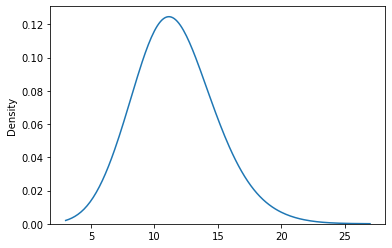

In [ ]:
import seaborn as sns
sns.kdeplot(data=orig_len, bw_adjust=5, cut=0)

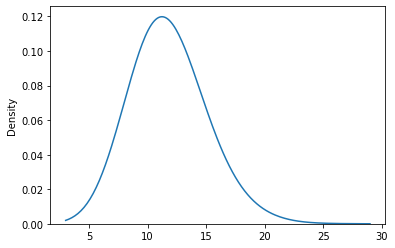

In [ ]:
sns.kdeplot(data=trans_len,bw_adjust=5, cut=0)

Следующий блок кода почти полностью повторяет рассмотренный на семинаре. Основное отличие – теперь `collate_tokens` работает сразу с исходным и с целевым языком (т.е. с двумя частями батча).

In [6]:
def copy_tensor(src:torch.Tensor, dst:torch.Tensor):
    assert dst.numel() == src.numel()
    dst.copy_(src)

    
pad_indices = [
    cyrillic_symbols.index('<PAD>'),
    latin_symbols.index('<PAD>')
]
def collate_tokens(values):
    results = [None, None]
    for idx in [0, 1]:
        max_len = max(v[idx].size(0) for v in values)
        res = torch.full((len(values), max_len),
                         pad_indices[idx],
                         dtype=torch.long,
                         device=values[0][idx].device)

        for i, v in enumerate(values):
            copy_tensor(v[idx], res[i][: len(v[idx])])
        results[idx] = res
    return results

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=collate_tokens)

batch = next(iter(dataloader))
print(batch[0].size(), batch[1].size())
print(batch)

torch.Size([128, 21]) torch.Size([128, 21])
[tensor([[34, 18,  3,  ..., 28, 10, 35],
        [34, 15,  8,  ..., 36, 36, 36],
        [34, 14,  1,  ..., 36, 36, 36],
        ...,
        [34, 11, 32,  ..., 36, 36, 36],
        [34, 16, 15,  ..., 36, 36, 36],
        [34, 10, 15,  ..., 36, 36, 36]]), tensor([[23, 17, 20,  ..., 21, 21, 24],
        [23, 14, 22,  ..., 25, 25, 25],
        [23, 13,  1,  ..., 25, 25, 25],
        ...,
        [23, 10, 21,  ..., 25, 25, 25],
        [23, 15, 14,  ..., 25, 25, 25],
        [23, 21, 14,  ..., 25, 25, 25]])]


Реализуйте `Encoder` в формате рекуррентной сети. Она может быть очень похожа на рассмотренную на семинаре. Возвращать она должна лишь свое скрытое состояние.

In [7]:
class EncoderModule(nn.Module):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super().__init__()
        self.embedding =  nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True)
        
    def forward(self, x):
        embed = self.embedding(x)
        output, state = self.lstm(embed)
        return state

Реализуйте `Decoder` в формате рекуррентной сети. Она может быть очень похожа на рассмотренную на семинаре.

В отличие от энкодера, ей на вход приходит и последовательность, и скрытое состояние энкодера. По умолчанию энкодер и декодер можно сделать с одинаковыми размерностями скрытых состояний.

Возвращать декодер должен логиты для предсказанных токенов (т.е. он очень похож на языковую модель с семинара).

In [8]:
class DecoderModule(nn.Module):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True)
        self.lm_head = nn.Linear(lstm_size, vocab_size)
        
    def forward(self, x, state):
        embed = self.embedding(x)
        output, _ = self.lstm(embed, state)
        logits = self.lm_head(output)
        return logits

Инициализация также знакома вам по практическому занятию

In [9]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = EncoderModule(len(cyrillic_symbols), 32, 128).to(device)
decoder = DecoderModule(len(latin_symbols), 32, 128).to(device)

Выберите подходящую функцию потерь. Не забывайте про различие между `nn.CrossEntropyLoss` и `nn.NLLLoss`, а также про PAD-токен (он должен обрабатываться особым образом).

In [10]:
criterion = nn.CrossEntropyLoss(ignore_index=latin_symbols.index('<PAD>'))

Если у вас есть несколько моделей, передать их параметры оптимизатору можно следующим образом:

In [11]:
optimizer = torch.optim.Adam((par for model in [encoder, decoder] for par in model.parameters()))

Запустите обучение модели. Базовый код дублирует код с семинара и уже работает.

**_Комментарий_**: _Обращаем ваше внимание, решаемая задача является упрощенной относительно классических задач машинного перевода. В данном случае декодер всегда получает на вход корректный токен, т.е. модель не работает в авторегрессионном режиме при обучении. Такой случай можно рассматривать как обучение со 100% teacher enforcing. Более сложные техники будут рассмотрены в следующих занятиях._

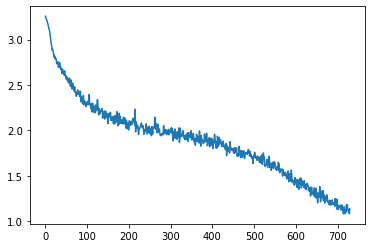

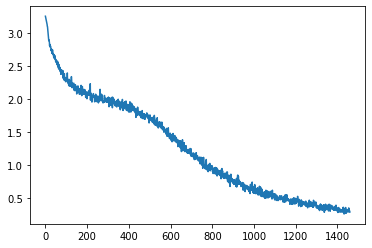

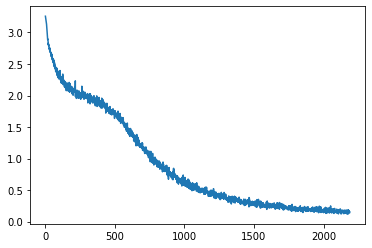

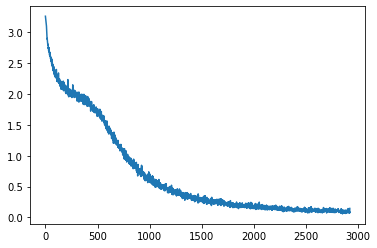

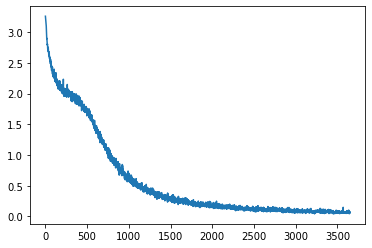

In [12]:
all_losses = []
NUM_EPOCHS = 5 #5

for epoch in range(NUM_EPOCHS):
    for idx, batch in enumerate(dataloader):
        batch = [batch_part.to(device) for batch_part in batch]
        state = encoder(batch[0]) # generate encoder hidden state
        lm_logits = decoder(batch[1], state) # pass encoder hidden state to decoder and generate target sequence

        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = batch[1][..., 1:].contiguous()
        

        loss = criterion(shift_logits.permute(0,2,1), shift_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        all_losses.append(loss.item())


    clear_output()
    plt.figure()
    plt.plot(all_losses)

Обращаем ваше внимание, одной эпохи может быть недостаточно для выхода функции потерь на плато.

Если модель была обучена, проведем визуальный анализ результатов. Следующие две функции дублируют код с семинара.

In [13]:
def top_k_top_p_filtering(logits, top_k = 0, top_p = 1.0, filter_value = -float("Inf"), min_tokens_to_keep = 1):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (batch size, vocabulary size)
            if top_k > 0: keep only top k tokens with highest probability (top-k filtering).
            if top_p < 1.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
            Make sure we keep at least min_tokens_to_keep per batch example in the output
        From: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """
    if top_k > 0:
        top_k = min(max(top_k, min_tokens_to_keep), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
        sorted_indices_to_remove = cumulative_probs > top_p
        if min_tokens_to_keep > 1:
            # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
            sorted_indices_to_remove[..., :min_tokens_to_keep] = 0
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return logits

def tokens_to_string(token_list):
    try:
        first_eos_index = token_list.index(latin_mapper['<EOS>'])
    except ValueError:
        first_eos_index = -1
    letters = [latin_symbols[token] for token in token_list[:first_eos_index]]
    return ''.join(
        letter for letter in letters if letter not in ('<BOS>', '<EOS>', '<PAD>')
    )

Для генерации транслитерации по заданному тексту доступна функция ниже.

_Обращаем ваше внимание, в словаре отсутствует пробел и символы верхнего регистра, а значит наша модель не может работать с целыми предложениями. Сначала нужно будет разделить их по словам и привести к нижнему регистру._

In [14]:
def get_transliteration(original_word, generation_iterations=32):
    word_as_tensor = torch.LongTensor(symbols_to_indices(original_word, cyrillic_mapper))
    state = encoder(word_as_tensor[None, ...].to(device))
    prefix = torch.full((1, 1),
                    latin_symbols.index('<BOS>'),
                    device=device, dtype=torch.long)
    
    for _ in range(generation_iterations):
        logits = decoder(prefix, state)[:, -1, :]
        filtered_logits = top_k_top_p_filtering(logits, top_k=10)
        probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
        tokens = torch.multinomial(probs, num_samples=1)
        prefix = torch.cat((prefix, tokens), dim=1)

    return(tokens_to_string(prefix[0].tolist()))

In [ ]:
examples_raw = [
    'шоссе',
    'резистентность',
    'эмбеддинг',
    'учитель',
    'коммивояжер',
    'кудесник',
    'парабола',
    'консистенция',
    'констебль',
    'факториал',
    'преамбула',
]

In [ ]:
for example in examples_raw:
    print('{} –> {}'.format(example, get_transliteration(example)))

шоссе –> stozfay
резистентность –> rezistetnostna
эмбеддинг –> mebednitya
учитель –> uchtiel
коммивояжер –> kommivozhayut
кудесник –> kudesnik
парабола –> parabola
консистенция –> konsistecin
констебль –> konstelt
факториал –> fatkorial
преамбула –> praemubla


Протестируйте модель на нескольких (~10) нестандартных словах. Что вы можете сказать о качестве транслитерации?

Путается порядок букв, но чаще всего угадывается само их наличие. Чем больше слово, тем хуже перевод, скорее всего из-за боттл нека при пеходе с енкодера на декодер. 

#### Оценка качества транслитерации в зависимости от позиции слова в тексте (10%)
Используя уже обученную модель, оцените точность транслитерации на обучающей выборке. 

Постройте график точности классификации от позиции символа.

In [15]:
from collections import Counter
dict_pos_n = Counter()
dict_pos_c = Counter()
for idx, batch in enumerate(dataloader):
        batch = [batch_part.to(device) for batch_part in batch]
        state = encoder(batch[0]) # generate encoder hidden state
        lm_logits = decoder(batch[1], state) # pass encoder hidden state to decoder and generate target sequence

        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = batch[1][..., 1:].contiguous()


        for n1,i in enumerate(shift_logits):
          for n2,j in enumerate(i):
            if shift_labels[n1,n2]!= 25:
              dict_pos_n[n2] += 1
              if np.argmax(j.cpu().detach().numpy()) == shift_labels[n1,n2]:
                dict_pos_c[n2] += 1


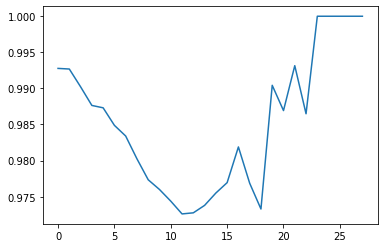

In [16]:
res_val = []
for i in range(len(dict_pos_n)):
  res_val.append(dict_pos_c[i]/dict_pos_n[i])
plt.plot(res_val)

#### Разделение выборки на обучение и тест (10%)
До текущего момента вся выборка использовалась для обучения модели. Вернитесь к началу части 2 и разделите выборку на обучающую, валидационную и тестовую выборки.

Обращаем ваше внимание, лучше разделить выборку случайным образом, т.к. оригинальный набор данных отсортирован в лексикографическом порядке.

In [ ]:
dataset_train, dataset_valtest = torch.utils.data.random_split(dataset,[int(dataset.__len__()*0.8), dataset.__len__() - int(dataset.__len__()*0.8)] , generator=torch.Generator().manual_seed(42))

In [ ]:
dataset_val, dataset_test = torch.utils.data.random_split(dataset_valtest,[int(dataset_valtest.__len__()*0.5), dataset_valtest.__len__() - int(dataset_valtest.__len__()*0.5)] , generator=torch.Generator().manual_seed(42))

In [ ]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, collate_fn=collate_tokens)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, collate_fn=collate_tokens)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, collate_fn=collate_tokens)

#### Построение end-to-end модели (20%)
Теперь объедините энкодер и декодер в один класс. Постарайтесь сделать его максимально простым. Используйте энкодер и декодер с различными размерностями скрытого состояния (т.е. вам нужно будет преобразовать состояние декодера, например, используя линейный слой).

Обучите модель заново только на обучающей выборке и замерьте время обучения (приведите усреденное значение на одну эпоху в конце данного блока). Также рекомендуем поэксперименировать с количеством эпох, learning rate и learning rate decay (например [ReduceLROnPlateau](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau))

Оцените качество модели на тестовой выборке (в том числе точность транслитерации в зависимости от позиции в слове). Оцените скорость применения модели (усредненное значение для одного батча).

_**Комментарий**: возможно, инвертирование текста на исходном языке (т.е. чтение его с конца, а не с начала) поможет вам добиться лучших результатов. Как вы думаете, почему?_

In [ ]:
class Seq2SeqTranslator(nn.Module):
    def __init__(self, vocab_size, embedding_size, gru_size_enc, gru_size_dec):
        super().__init__()
        self.embedding_enc = nn.Embedding(vocab_size, embedding_size)
        self.embedding_dec = nn.Embedding(vocab_size, embedding_size)
        self.gru_enc = nn.GRU(embedding_size,
                            gru_size_enc,
                            batch_first=True)
        self.gru_dec = nn.GRU(embedding_size,
                            gru_size_dec,
                            batch_first=True)
        self.lm_in = nn.Linear(gru_size_enc, gru_size_dec)
        self.lm_head = nn.Linear(gru_size_dec, vocab_size)

    def forward(self, x_rus, x_eng):
        embed_rus = self.embedding_enc(x_rus)
        output, state = self.gru_enc(embed_rus)
        state_new = self.lm_in(state)
        embed_eng = self.embedding_dec(x_eng)
        output, state_last = self.gru_dec(embed_eng, state_new)
        logits = self.lm_head(output)
        return logits

In [ ]:
loss_train = []
loss_val = []
NUM_EPOCHS = 4 #5
seq2seq = Seq2SeqTranslator(len(cyrillic_symbols), 32, 64, 128).to(device)
optimizer = torch.optim.Adam(seq2seq.parameters())

for epoch in range(NUM_EPOCHS):
    for idx, batch in enumerate(dataloader_train):
        batch_train = [batch_part.to(device) for batch_part in batch]
        lm_logits = seq2seq(batch_train[0], batch_train[1]) # pass encoder hidden state to decoder and generate target sequence



        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = batch_train[1][..., 1:].contiguous()
        

        loss = criterion(shift_logits.permute(0,2,1), shift_labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_train.append(loss.item())

    for idx, batch in enumerate(dataloader_val):
        batch_val = [batch_part.to(device) for batch_part in batch]
        lm_logits = seq2seq(batch_val[0], batch_val[1]) # pass encoder hidden state to decoder and generate target sequence

        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = batch_val[1][..., 1:].contiguous()

        loss = criterion(shift_logits.permute(0,2,1), shift_labels.to(device))

        loss_val.append(loss.item())


    #clear_output()
    #plt.figure()
    #plt.plot(loss_train)
    #plt.plot(loss_val)


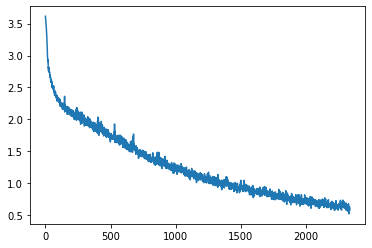

In [ ]:
plt.plot(loss_train)

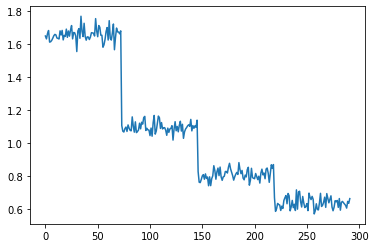

In [ ]:
plt.plot(loss_val)

In [ ]:
from collections import Counter
dict_pos_n = Counter()
dict_pos_c = Counter()
for idx, batch in enumerate(dataloader_test):
        batch = [batch_part.to(device) for batch_part in batch]
        lm_logits = seq2seq(batch[0], batch[1])

        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = batch[1][..., 1:].contiguous()


        for n1,i in enumerate(shift_logits):
          for n2,j in enumerate(i):
            if shift_labels[n1,n2]!= 25:
              dict_pos_n[n2] += 1
              if np.argmax(j.cpu().detach().numpy()) == shift_labels[n1,n2]:
                dict_pos_c[n2] += 1


In [ ]:
res_val = []
for i in range(len(dict_pos_n)):
  res_val.append(dict_pos_c[i]/dict_pos_n[i])


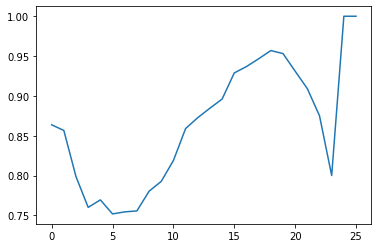

In [ ]:
plt.plot(res_val)

__Бонусное задание**: использование Attention (+10-30%)__

В качестве бонусного задания вас ждет реализация решения с использованием механизма Attention. За примером можно обратиться к [данной статье](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), или же воспользоваться одним из примеров в сети.

Ваша цель состоит в следующем:
1. Реализовать Attention слой (или адаптировать доступный в сети).
2. Обучить модель с использованием Attention и оценить время ее обучения.
3. Оценить результаты аналогично предыдущему шагу и сравнить результаты и скорость работы.

In [ ]:
# your bonus code here

#### Выводы
Cформулируйте выводы на основании проделанной работы. Как соотносятся результаты на тестовой и обучающей выборке между собой? Зависит ли качество транслитерации от направления чтения текста? Позволил ли Attention добиться лучших результатов? Какие шаги данного задания показались вам интереснее всего?


### Выводы:
_Ваши замечательные выводы_

Пожалуйста, оставьте обратную связь о задании [по ссылке](http://rebrand.ly/mfnlp2020q4_feedback_hw05). Она (при желании) анонимна ;)